<a href="https://colab.research.google.com/github/omkar17MM02001/Count-Polygons-in-image-using-CNN-with-transfer-learning/blob/main/voronoi_genus_count8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/voro_train_final/voro_train2.zip' -d '/content/drive/MyDrive/voro_train_final'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro5000_2718.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro5000_3716.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro5000_4004.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro5000_4533.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro701_636.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro8001_115.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro9001_1079.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/463/voro9001_1694.png  
   creating: /content/drive/MyDrive/voro_train_final/voro_train/464/
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/464/voro1001_52.png  
  inflating: /content/drive/MyDrive/voro_train_final/voro_train/464/voro701_244.png  
  infla

In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time

In [ ]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = '/content/drive/MyDrive/voro_train_final/voro_train3'  
validation_data_dir = '/content/drive/MyDrive/voro_validation1/voro_validation'  
test_data_dir = '/content/drive/MyDrive/voro_test1/voro_test'
   
# number of epochs to train top model  
epochs = 9

# batch size used by flow_from_directory and predict_generator  
batch_size = 85

In [ ]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [ ]:

datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [ ]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 10065 images belonging to 1000 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  1:16:24.235454


In [ ]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2080 images belonging to 1000 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:18:02.248955


In [ ]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1800 images belonging to 1000 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:13:54.275088


In [ ]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='binary',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 10065 images belonging to 1000 classes.


In [ ]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2080 images belonging to 1000 classes.


In [ ]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1800 images belonging to 1000 classes.


In [ ]:
#### start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=500,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/500
119/119 [==============================] - 7s 50ms/step - loss: 6.8451 - acc: 0.0026 - val_loss: 6.4453 - val_acc: 0.0115
Epoch 2/500
119/119 [==============================] - 6s 47ms/step - loss: 6.4642 - acc: 0.0084 - val_loss: 5.9987 - val_acc: 0.0168
Epoch 3/500
119/119 [==============================] - 6s 48ms/step - loss: 6.0892 - acc: 0.0120 - val_loss: 5.7499 - val_acc: 0.0216
Epoch 4/500
119/119 [==============================] - 6s 48ms/step - loss: 5.8493 - acc: 0.0183 - val_loss: 5.5355 - val_acc: 0.0327
Epoch 5/500
119/119 [==============================] - 6s 48ms/step - loss: 5.6328 - acc: 0.0219 - val_loss: 5.3596 - val_acc: 0.0428
Epoch 6/500
119/119 [==============================] - 6s 48ms/step - loss: 5.4895 - acc: 0.0307 - val_loss: 5.2097 - val_acc: 0.0466
Epoch 7/500
119/119 [==============================] - 6s 48ms/step - loss: 5.3626 - acc: 0.0338 - val_loss: 5.0511 - val_acc: 0.0788
Epoch 8/500
119/119 [==============================] - 6s 48ms

In [ ]:
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              51000     
Total params: 2,564,950
Trainable params: 2,564,950
Non-trainable params: 0
______________________________________________

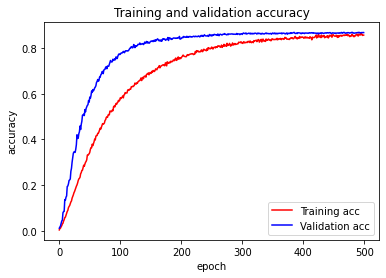

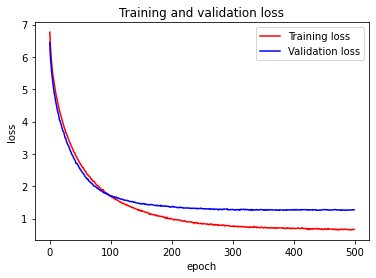

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

57/57 [==============================] - 0s 7ms/step - loss: 1.8003 - acc: 0.8139


[1.8003227710723877, 0.8138889074325562]

In [ ]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.19662541 0.         0.         ... 0.         0.67386144
    0.        ]
   [0.08873171 0.         0.         ... 0.         0.72546875
    0.        ]
   [0.         0.         0.         ... 0.         0.6405084
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.85762024
    0.        ]
   [0.5085098  0.         0.         ... 0.         0.80316645
    0.        ]
   [0.40184793 0.         0.         ... 0.         0.8567537
    0.        ]]

  [[0.         0.         0.         ... 0.         0.61431915
    0.        ]
   [0.         0.         0.22545463 ... 0.         0.6258276
    0.        ]
   [0.         0.         0.27633202 ... 0.         0.51669526
    0.        ]
   ...
   [0.05812159 0.         0.47026694 ... 0.         0.56397605
    0.        ]
   [0.5304783  0.         0.3703599  ... 0.         0.6709764
    0.        ]
   [0.5379713  0.         0.         ... 0.         1.0199517
    0.        ]]

  [[0.         0.         0. 

In [ ]:
genus=['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '209',
 '210',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '219',
 '220',
 '221',
 '222',
 '223',
 '224',
 '225',
 '226',
 '227',
 '228',
 '229',
 '230',
 '231',
 '232',
 '233',
 '234',
 '235',
 '236',
 '237',
 '238',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '248',
 '249',
 '250',
 '251',
 '252',
 '253',
 '254',
 '255',
 '256',
 '257',
 '258',
 '259',
 '260',
 '261',
 '262',
 '263',
 '264',
 '265',
 '266',
 '267',
 '268',
 '269',
 '270',
 '271',
 '272',
 '273',
 '274',
 '275',
 '276',
 '277',
 '278',
 '279',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289',
 '290',
 '291',
 '292',
 '293',
 '294',
 '295',
 '296',
 '297',
 '298',
 '299',
 '300',
 '301',
 '302',
 '303',
 '304',
 '305',
 '306',
 '307',
 '308',
 '309',
 '310',
 '311',
 '312',
 '313',
 '314',
 '315',
 '316',
 '317',
 '318',
 '319',
 '320',
 '321',
 '322',
 '323',
 '324',
 '325',
 '326',
 '327',
 '328',
 '329',
 '330',
 '331',
 '332',
 '333',
 '334',
 '335',
 '336',
 '337',
 '338',
 '339',
 '340',
 '341',
 '342',
 '343',
 '344',
 '345',
 '346',
 '347',
 '348',
 '349',
 '350',
 '351',
 '352',
 '353',
 '354',
 '355',
 '356',
 '357',
 '358',
 '359',
 '360',
 '361',
 '362',
 '363',
 '364',
 '365',
 '366',
 '367',
 '368',
 '369',
 '370',
 '371',
 '372',
 '373',
 '374',
 '375',
 '376',
 '377',
 '378',
 '379',
 '380',
 '381',
 '382',
 '383',
 '384',
 '385',
 '386',
 '387',
 '388',
 '389',
 '390',
 '391',
 '392',
 '393',
 '394',
 '395',
 '396',
 '397',
 '398',
 '399',
 '400',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '417',
 '418',
 '419',
 '420',
 '421',
 '422',
 '423',
 '424',
 '425',
 '426',
 '427',
 '428',
 '429',
 '430',
 '431',
 '432',
 '433',
 '434',
 '435',
 '436',
 '437',
 '438',
 '439',
 '440',
 '441',
 '442',
 '443',
 '444',
 '445',
 '446',
 '447',
 '448',
 '449',
 '450',
 '451',
 '452',
 '453',
 '454',
 '455',
 '456',
 '457',
 '458',
 '459',
 '460',
 '461',
 '462',
 '463',
 '464',
 '465',
 '466',
 '467',
 '468',
 '469',
 '470',
 '471',
 '472',
 '473',
 '474',
 '475',
 '476',
 '477',
 '478',
 '479',
 '480',
 '481',
 '482',
 '483',
 '484',
 '485',
 '486',
 '487',
 '488',
 '489',
 '490',
 '491',
 '492',
 '493',
 '494',
 '495',
 '496',
 '497',
 '498',
 '499',
 '500',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '508',
 '509',
 '510',
 '511',
 '512',
 '513',
 '514',
 '515',
 '516',
 '517',
 '518',
 '519',
 '520',
 '521',
 '522',
 '523',
 '524',
 '525',
 '526',
 '527',
 '528',
 '529',
 '530',
 '531',
 '532',
 '533',
 '534',
 '535',
 '536',
 '537',
 '538',
 '539',
 '540',
 '541',
 '542',
 '543',
 '544',
 '545',
 '546',
 '547',
 '548',
 '549',
 '550',
 '551',
 '552',
 '553',
 '554',
 '555',
 '556',
 '557',
 '558',
 '559',
 '560',
 '561',
 '562',
 '563',
 '564',
 '565',
 '566',
 '567',
 '568',
 '569',
 '570',
 '571',
 '572',
 '573',
 '574',
 '575',
 '576',
 '577',
 '578',
 '579',
 '580',
 '581',
 '582',
 '583',
 '584',
 '585',
 '586',
 '587',
 '588',
 '589',
 '590',
 '591',
 '592',
 '593',
 '594',
 '595',
 '596',
 '597',
 '598',
 '599',
 '600',
 '601',
 '602',
 '603',
 '604',
 '605',
 '606',
 '607',
 '608',
 '609',
 '610',
 '611',
 '612',
 '613',
 '614',
 '615',
 '616',
 '617',
 '618',
 '619',
 '620',
 '621',
 '622',
 '623',
 '624',
 '625',
 '626',
 '627',
 '628',
 '629',
 '630',
 '631',
 '632',
 '633',
 '634',
 '635',
 '636',
 '637',
 '638',
 '639',
 '640',
 '641',
 '642',
 '643',
 '644',
 '645',
 '646',
 '647',
 '648',
 '649',
 '650',
 '651',
 '652',
 '653',
 '654',
 '655',
 '656',
 '657',
 '658',
 '659',
 '660',
 '661',
 '662',
 '663',
 '664',
 '665',
 '666',
 '667',
 '668',
 '669',
 '670',
 '671',
 '672',
 '673',
 '674',
 '675',
 '676',
 '677',
 '678',
 '679',
 '680',
 '681',
 '682',
 '683',
 '684',
 '685',
 '686',
 '687',
 '688',
 '689',
 '690',
 '691',
 '692',
 '693',
 '694',
 '695',
 '696',
 '697',
 '698',
 '699',
 '700',
 '701',
 '702',
 '703',
 '704',
 '705',
 '706',
 '707',
 '708',
 '709',
 '710',
 '711',
 '712',
 '713',
 '714',
 '715',
 '716',
 '717',
 '718',
 '719',
 '720',
 '721',
 '722',
 '723',
 '724',
 '725',
 '726',
 '727',
 '728',
 '729',
 '730',
 '731',
 '732',
 '733',
 '734',
 '735',
 '736',
 '737',
 '738',
 '739',
 '740',
 '741',
 '742',
 '743',
 '744',
 '745',
 '746',
 '747',
 '748',
 '749',
 '750',
 '751',
 '752',
 '753',
 '754',
 '755',
 '756',
 '757',
 '758',
 '759',
 '760',
 '761',
 '762',
 '763',
 '764',
 '765',
 '766',
 '767',
 '768',
 '769',
 '770',
 '771',
 '772',
 '773',
 '774',
 '775',
 '776',
 '777',
 '778',
 '779',
 '780',
 '781',
 '782',
 '783',
 '784',
 '785',
 '786',
 '787',
 '788',
 '789',
 '790',
 '791',
 '792',
 '793',
 '794',
 '795',
 '796',
 '797',
 '798',
 '799',
 '800',
 '801',
 '802',
 '803',
 '804',
 '805',
 '806',
 '807',
 '808',
 '809',
 '810',
 '811',
 '812',
 '813',
 '814',
 '815',
 '816',
 '817',
 '818',
 '819',
 '820',
 '821',
 '822',
 '823',
 '824',
 '825',
 '826',
 '827',
 '828',
 '829',
 '830',
 '831',
 '832',
 '833',
 '834',
 '835',
 '836',
 '837',
 '838',
 '839',
 '840',
 '841',
 '842',
 '843',
 '844',
 '845',
 '846',
 '847',
 '848',
 '849',
 '850',
 '851',
 '852',
 '853',
 '854',
 '855',
 '856',
 '857',
 '858',
 '859',
 '860',
 '861',
 '862',
 '863',
 '864',
 '865',
 '866',
 '867',
 '868',
 '869',
 '870',
 '871',
 '872',
 '873',
 '874',
 '875',
 '876',
 '877',
 '878',
 '879',
 '880',
 '881',
 '882',
 '883',
 '884',
 '885',
 '886',
 '887',
 '888',
 '889',
 '890',
 '891',
 '892',
 '893',
 '894',
 '895',
 '896',
 '897',
 '898',
 '899',
 '900',
 '901',
 '902',
 '903',
 '904',
 '905',
 '906',
 '907',
 '908',
 '909',
 '910',
 '911',
 '912',
 '913',
 '914',
 '915',
 '916',
 '917',
 '918',
 '919',
 '920',
 '921',
 '922',
 '923',
 '924',
 '925',
 '926',
 '927',
 '928',
 '929',
 '930',
 '931',
 '932',
 '933',
 '934',
 '935',
 '936',
 '937',
 '938',
 '939',
 '940',
 '941',
 '942',
 '943',
 '944',
 '945',
 '946',
 '947',
 '948',
 '949',
 '950',
 '951',
 '952',
 '953',
 '954',
 '955',
 '956',
 '957',
 '958',
 '959',
 '960',
 '961',
 '962',
 '963',
 '964',
 '965',
 '966',
 '967',
 '968',
 '969',
 '970',
 '971',
 '972',
 '973',
 '974',
 '975',
 '976',
 '977',
 '978',
 '979',
 '980',
 '981',
 '982',
 '983',
 '984',
 '985',
 '986',
 '987',
 '988',
 '989',
 '990',
 '991',
 '992',
 '993',
 '994',
 '995',
 '996',
 '997',
 '998',
 '999',
 '1000']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=genus)
print(classification_metrics)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00        20
           7       0.00      0.00      0.00         0
           8       1.00      0.78      0.88         9
           9       1.00      1.00      1.00         6
          10       0.00      0.00      0.00         6
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        18
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         6
          16       1.00      0.80      0.89        10
          17       1.00      1.00      1.00         6
          18       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
#Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [ ]:
def test_single_image(path):
    genus =['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '209',
 '210',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '219',
 '220',
 '221',
 '222',
 '223',
 '224',
 '225',
 '226',
 '227',
 '228',
 '229',
 '230',
 '231',
 '232',
 '233',
 '234',
 '235',
 '236',
 '237',
 '238',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '248',
 '249',
 '250',
 '251',
 '252',
 '253',
 '254',
 '255',
 '256',
 '257',
 '258',
 '259',
 '260',
 '261',
 '262',
 '263',
 '264',
 '265',
 '266',
 '267',
 '268',
 '269',
 '270',
 '271',
 '272',
 '273',
 '274',
 '275',
 '276',
 '277',
 '278',
 '279',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289',
 '290',
 '291',
 '292',
 '293',
 '294',
 '295',
 '296',
 '297',
 '298',
 '299',
 '300',
 '301',
 '302',
 '303',
 '304',
 '305',
 '306',
 '307',
 '308',
 '309',
 '310',
 '311',
 '312',
 '313',
 '314',
 '315',
 '316',
 '317',
 '318',
 '319',
 '320',
 '321',
 '322',
 '323',
 '324',
 '325',
 '326',
 '327',
 '328',
 '329',
 '330',
 '331',
 '332',
 '333',
 '334',
 '335',
 '336',
 '337',
 '338',
 '339',
 '340',
 '341',
 '342',
 '343',
 '344',
 '345',
 '346',
 '347',
 '348',
 '349',
 '350',
 '351',
 '352',
 '353',
 '354',
 '355',
 '356',
 '357',
 '358',
 '359',
 '360',
 '361',
 '362',
 '363',
 '364',
 '365',
 '366',
 '367',
 '368',
 '369',
 '370',
 '371',
 '372',
 '373',
 '374',
 '375',
 '376',
 '377',
 '378',
 '379',
 '380',
 '381',
 '382',
 '383',
 '384',
 '385',
 '386',
 '387',
 '388',
 '389',
 '390',
 '391',
 '392',
 '393',
 '394',
 '395',
 '396',
 '397',
 '398',
 '399',
 '400',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '417',
 '418',
 '419',
 '420',
 '421',
 '422',
 '423',
 '424',
 '425',
 '426',
 '427',
 '428',
 '429',
 '430',
 '431',
 '432',
 '433',
 '434',
 '435',
 '436',
 '437',
 '438',
 '439',
 '440',
 '441',
 '442',
 '443',
 '444',
 '445',
 '446',
 '447',
 '448',
 '449',
 '450',
 '451',
 '452',
 '453',
 '454',
 '455',
 '456',
 '457',
 '458',
 '459',
 '460',
 '461',
 '462',
 '463',
 '464',
 '465',
 '466',
 '467',
 '468',
 '469',
 '470',
 '471',
 '472',
 '473',
 '474',
 '475',
 '476',
 '477',
 '478',
 '479',
 '480',
 '481',
 '482',
 '483',
 '484',
 '485',
 '486',
 '487',
 '488',
 '489',
 '490',
 '491',
 '492',
 '493',
 '494',
 '495',
 '496',
 '497',
 '498',
 '499',
 '500',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '508',
 '509',
 '510',
 '511',
 '512',
 '513',
 '514',
 '515',
 '516',
 '517',
 '518',
 '519',
 '520',
 '521',
 '522',
 '523',
 '524',
 '525',
 '526',
 '527',
 '528',
 '529',
 '530',
 '531',
 '532',
 '533',
 '534',
 '535',
 '536',
 '537',
 '538',
 '539',
 '540',
 '541',
 '542',
 '543',
 '544',
 '545',
 '546',
 '547',
 '548',
 '549',
 '550',
 '551',
 '552',
 '553',
 '554',
 '555',
 '556',
 '557',
 '558',
 '559',
 '560',
 '561',
 '562',
 '563',
 '564',
 '565',
 '566',
 '567',
 '568',
 '569',
 '570',
 '571',
 '572',
 '573',
 '574',
 '575',
 '576',
 '577',
 '578',
 '579',
 '580',
 '581',
 '582',
 '583',
 '584',
 '585',
 '586',
 '587',
 '588',
 '589',
 '590',
 '591',
 '592',
 '593',
 '594',
 '595',
 '596',
 '597',
 '598',
 '599',
 '600',
 '601',
 '602',
 '603',
 '604',
 '605',
 '606',
 '607',
 '608',
 '609',
 '610',
 '611',
 '612',
 '613',
 '614',
 '615',
 '616',
 '617',
 '618',
 '619',
 '620',
 '621',
 '622',
 '623',
 '624',
 '625',
 '626',
 '627',
 '628',
 '629',
 '630',
 '631',
 '632',
 '633',
 '634',
 '635',
 '636',
 '637',
 '638',
 '639',
 '640',
 '641',
 '642',
 '643',
 '644',
 '645',
 '646',
 '647',
 '648',
 '649',
 '650',
 '651',
 '652',
 '653',
 '654',
 '655',
 '656',
 '657',
 '658',
 '659',
 '660',
 '661',
 '662',
 '663',
 '664',
 '665',
 '666',
 '667',
 '668',
 '669',
 '670',
 '671',
 '672',
 '673',
 '674',
 '675',
 '676',
 '677',
 '678',
 '679',
 '680',
 '681',
 '682',
 '683',
 '684',
 '685',
 '686',
 '687',
 '688',
 '689',
 '690',
 '691',
 '692',
 '693',
 '694',
 '695',
 '696',
 '697',
 '698',
 '699',
 '700',
 '701',
 '702',
 '703',
 '704',
 '705',
 '706',
 '707',
 '708',
 '709',
 '710',
 '711',
 '712',
 '713',
 '714',
 '715',
 '716',
 '717',
 '718',
 '719',
 '720',
 '721',
 '722',
 '723',
 '724',
 '725',
 '726',
 '727',
 '728',
 '729',
 '730',
 '731',
 '732',
 '733',
 '734',
 '735',
 '736',
 '737',
 '738',
 '739',
 '740',
 '741',
 '742',
 '743',
 '744',
 '745',
 '746',
 '747',
 '748',
 '749',
 '750',
 '751',
 '752',
 '753',
 '754',
 '755',
 '756',
 '757',
 '758',
 '759',
 '760',
 '761',
 '762',
 '763',
 '764',
 '765',
 '766',
 '767',
 '768',
 '769',
 '770',
 '771',
 '772',
 '773',
 '774',
 '775',
 '776',
 '777',
 '778',
 '779',
 '780',
 '781',
 '782',
 '783',
 '784',
 '785',
 '786',
 '787',
 '788',
 '789',
 '790',
 '791',
 '792',
 '793',
 '794',
 '795',
 '796',
 '797',
 '798',
 '799',
 '800',
 '801',
 '802',
 '803',
 '804',
 '805',
 '806',
 '807',
 '808',
 '809',
 '810',
 '811',
 '812',
 '813',
 '814',
 '815',
 '816',
 '817',
 '818',
 '819',
 '820',
 '821',
 '822',
 '823',
 '824',
 '825',
 '826',
 '827',
 '828',
 '829',
 '830',
 '831',
 '832',
 '833',
 '834',
 '835',
 '836',
 '837',
 '838',
 '839',
 '840',
 '841',
 '842',
 '843',
 '844',
 '845',
 '846',
 '847',
 '848',
 '849',
 '850',
 '851',
 '852',
 '853',
 '854',
 '855',
 '856',
 '857',
 '858',
 '859',
 '860',
 '861',
 '862',
 '863',
 '864',
 '865',
 '866',
 '867',
 '868',
 '869',
 '870',
 '871',
 '872',
 '873',
 '874',
 '875',
 '876',
 '877',
 '878',
 '879',
 '880',
 '881',
 '882',
 '883',
 '884',
 '885',
 '886',
 '887',
 '888',
 '889',
 '890',
 '891',
 '892',
 '893',
 '894',
 '895',
 '896',
 '897',
 '898',
 '899',
 '900',
 '901',
 '902',
 '903',
 '904',
 '905',
 '906',
 '907',
 '908',
 '909',
 '910',
 '911',
 '912',
 '913',
 '914',
 '915',
 '916',
 '917',
 '918',
 '919',
 '920',
 '921',
 '922',
 '923',
 '924',
 '925',
 '926',
 '927',
 '928',
 '929',
 '930',
 '931',
 '932',
 '933',
 '934',
 '935',
 '936',
 '937',
 '938',
 '939',
 '940',
 '941',
 '942',
 '943',
 '944',
 '945',
 '946',
 '947',
 '948',
 '949',
 '950',
 '951',
 '952',
 '953',
 '954',
 '955',
 '956',
 '957',
 '958',
 '959',
 '960',
 '961',
 '962',
 '963',
 '964',
 '965',
 '966',
 '967',
 '968',
 '969',
 '970',
 '971',
 '972',
 '973',
 '974',
 '975',
 '976',
 '977',
 '978',
 '979',
 '980',
 '981',
 '982',
 '983',
 '984',
 '985',
 '986',
 '987',
 '988',
 '989',
 '990',
 '991',
 '992',
 '993',
 '994',
 '995',
 '996',
 '997',
 '998',
 '999',
 '1000']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction =vgg16.predict(images) 
    preds = model.predict_proba(bt_prediction)
    for idx, gen, x in zip(range(1,1000), genus , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, gen, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [ ]:
path = '/content/drive/MyDrive/voro_final_test/voro500_20.png'

[INFO] loading and preprocessing image...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ID: 1, Label: 1 0.0%
ID: 2, Label: 2 0.0%
ID: 3, Label: 3 0.0%
ID: 4, Label: 4 0.0%
ID: 5, Label: 5 0.01%
ID: 6, Label: 6 0.0%
ID: 7, Label: 7 0.0%
ID: 8, Label: 8 0.0%
ID: 9, Label: 9 0.0%
ID: 10, Label: 10 0.0%
ID: 11, Label: 11 0.0%
ID: 12, Label: 12 0.0%
ID: 13, Label: 13 0.0%
ID: 14, Label: 14 0.0%
ID: 15, Label: 15 0.0%
ID: 16, Label: 16 0.0%
ID: 17, Label: 17 0.0%
ID: 18, Label: 18 0.0%
ID: 19, Label: 19 0.0%
ID: 20, Label: 20 0.0%
ID: 21, Label: 21 0.0%
ID: 22, Label: 22 0.0%
ID: 23, Label: 23 0.0%
ID: 24, Label: 24 0.0%
ID: 25, Label: 25 0.0%
ID: 26, Label: 26 0.0%
ID: 27, Label: 27 0.0%
ID: 28, Label: 28 0.0%
ID: 29, Label: 29 0.0%
ID: 30, Label: 30 0.0%
ID: 31, Label: 31 0.0%
ID: 32, Label: 32 0.0%
ID: 33, Label: 33 0.0%
ID: 34, Label: 34 0.0%
ID: 35, Label: 35 0.0%
ID: 36, Label: 36 0.0%
ID: 37, Label: 37 0.0%
ID: 38, Label: 38 0.0%
ID: 39, Label: 39 0.0%
ID: 40, Label: 40 0.0%
ID: 41, Label: 41 0.0%
ID: 42, Label: 42 0.0%
ID: 43, Label: 43 0.02%
ID: 44, Label: 44 0.0%
ID: 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


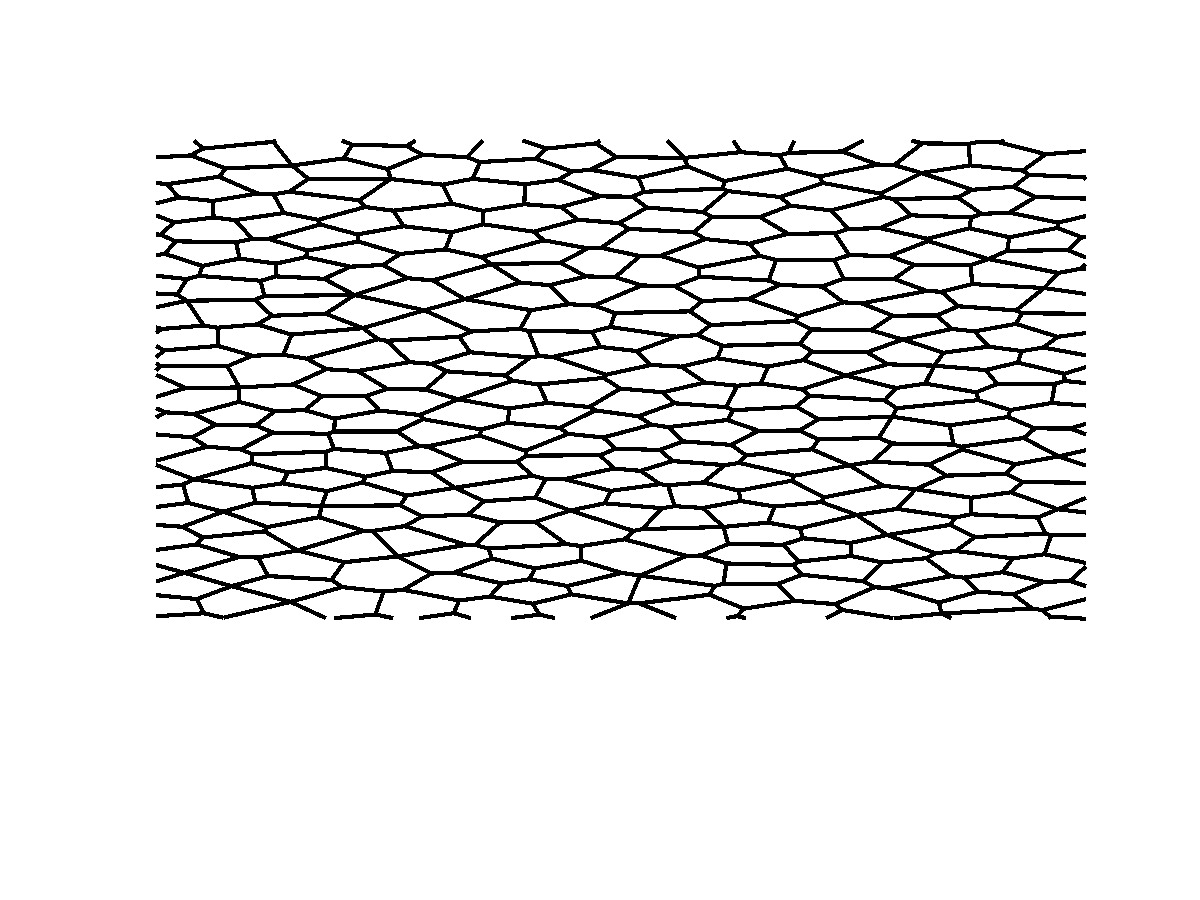

In [ ]:
test_single_image(path)